# Step-by-Step guide on How to Use Multi-class TwinSVM on Wine Dataset.

**Note:** Before running this notebook, make sure that LightTwinSVM program is installed.

## Read datatset

For this tutorial, Wine dataset will be used. However, you can use your own dataset by changing following path. <br />
For reading CSV file, pandas package is used. <br />
**Note:** Please make sure that your dataset is comptabile with the [LightTwinSVM's dataset format](https://github.com/mir-am/LightTwinSVM#dataset-format).

In [1]:
import pandas as pd

dataset_path = '../dataset/wine.csv'
dataset = pd.read_csv(dataset_path)
dataset.head()

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,class,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,1,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,1,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,1,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


## Prepare training samples and class labels
In order to improve generalization and reduce variance, we need to shuffle the samples of dataset. 

In [2]:
from sklearn.utils import shuffle 

dataset = shuffle(dataset)
dataset.head()

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,class,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
59,2,-0.778980,-1.253450,-3.679162,-2.671018,-0.824415,-0.504914,-1.465058,-0.659563,-2.051513,-1.344466,0.406051,-1.118210,-0.722540
63,2,-0.778980,-1.082894,-0.754890,-0.148624,-0.894628,1.930629,1.074978,-1.384766,0.489009,-0.263041,1.151898,0.364855,-1.040990
26,1,0.480990,-0.508390,0.926567,-1.019451,-0.473348,0.889114,0.914343,-0.176095,-0.246867,-0.111642,-0.164303,0.859210,1.426993
51,1,1.024507,-0.616110,0.853460,-0.689137,-0.403135,0.248181,0.964541,-1.143031,1.224884,0.234414,1.239645,1.071076,1.649908
172,3,1.432144,0.155881,0.414820,0.151661,-0.613775,-0.985614,-1.334543,0.629686,-0.614804,2.007951,-1.480505,-1.273579,-0.276711


In this step, samples and their corresponding labels is converted to Numpy arrays which is necessary for running the classifier.

In [3]:
X_train = dataset.iloc[:, 1:].values # Features' values
y_true = dataset.iloc[:, 0].values

array([2, 2, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 2, 1, 3, 3, 3, 2, 2, 3,
       2, 1, 2, 2, 2, 3, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 3, 3, 2, 1, 2, 2,
       1, 3, 1, 3, 2, 1, 3, 3, 2, 2, 2, 1, 1, 3, 1, 2, 2, 2, 3, 1, 1, 3,
       3, 2, 3, 1, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 3, 3, 2, 2, 3, 3,
       1, 2, 3, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 2, 1, 3, 2, 2, 2, 2, 1,
       1, 3, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 3, 2, 1,
       1, 3, 3, 1, 1, 2, 2, 3, 3, 3, 3, 1, 2, 1, 1, 2, 2, 3, 1, 2, 3, 2,
       1, 1, 3, 2, 1, 2, 3, 2, 1, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3,
       1, 1])

## Using LightTwinSVM for classification

To use LightTwinSVM modules, its path should be added to PYTHON PATH

In [4]:
import sys

sys.path.insert(0, '../src/')

It's time to create an instance of TwinSVM classifier

In [5]:
import twinsvm as tsvm

# Choose a kernel
kernel = 'RBF'

tsvm_model = tsvm.OVO_TSVM(kernel=kernel)

### Specify range of hyper-parameters for grid search

Performance of TwinSVM classifier is highly dependent upon the choice of hyper-parameters. Therefore, using a search method to find optimal values of these parameters is essential. <br />
In this guide, C parameter is chosen from the following set:
$$C = \{2^{i}|i=-6,-5,\dots, 4\}$$

In [6]:
c_range = {'C_1': [float(2**i) for i in range(-6, 5)],
           'C_2': [float(2**i) for i in range(-6, 5)]}

gamma_range = {'gamma': [float(2**i) for i in range(-8, 3)]} if kernel == 'RBF' else {}

param_range = {**c_range, **gamma_range}

To evaluate the classifier, K-Fold Cross validation is often used. <br />

In [7]:
from sklearn.model_selection import GridSearchCV

cv_folds = 5

result = GridSearchCV(tsvm_model, param_range, cv=cv_folds, verbose=1)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Start grid search! Based on your hardware speed, it takes about 3~4 minutes.

In [8]:
result.fit(X_train, y_true)

Fitting 5 folds for each of 1331 candidates, totalling 6655 fits


[Parallel(n_jobs=1)]: Done 6655 out of 6655 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=OVO_TSVM(C_1=1, C_2=1, gamma=1, kernel='RBF'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0], 'C_2': [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0], 'C_1': [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

### Evaluation of classification result

After grid search, the best model is found and its accuracy is as follows:

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

best_mean_score = result.cv_results_['mean_test_score'][result.best_index_]
best_std_score = result.cv_results_['std_test_score'][result.best_index_]

print("Best score: %.2f+-%.2f" % (best_mean_score * 100, best_std_score * 100))

Best score: 99.44+-1.14


### Confusion matrix

To interpret the classification result, confusion matrix is a great choice.

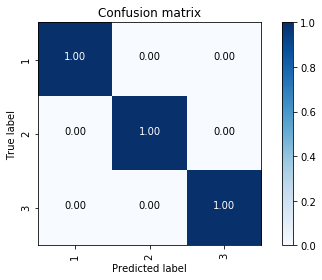

In [16]:
from misc import plt_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Predict data with pre-trained model
y_pred = result.best_estimator_.predict(X_train)

cm = confusion_matrix(y_true, y_pred)
plt_confusion_matrix(cm, np.unique(y_true))

# Uncomment this if you want to save the confusion matrix
#plt.savefig("Wine_cm.png", dpi=128)

### Full classification report 

Precision, recall and F1-measure for each class

In [11]:
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          1       1.00      1.00      1.00        59
          2       1.00      1.00      1.00        71
          3       1.00      1.00      1.00        48

avg / total       1.00      1.00      1.00       178

